In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

# Funs

In [10]:
def prep_data(sim):
    X = np.stack([eeg.average().data for eeg in sim.eeg_data])
    y = np.stack([src.data for src in sim.source_data])
    for i, (x_sample, y_sample) in enumerate(zip(X, y)):
        # X[i] = np.stack([(x - np.mean(x)) / np.std(x) for x in x_sample.T], axis=0).T
        # y[i] = np.stack([ y / np.max(abs(y)) for y in y_sample.T], axis=0).T

        X[i] = np.stack([x - np.mean(x) for x in x_sample.T], axis=0).T
        X[i] /= np.linalg.norm(X[i])
        y[i] /= np.max(abs(y[i]))

    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    
    return X, y
    
def make_mask(y, thresh=0.001):
    y_mask = np.zeros((y.shape[0], n_dipoles))
    for i, y_samp in enumerate(y):
        yy = abs(y_samp).mean(axis=0)
        

        y_mask[i] = (yy > yy.max()*thresh).astype(int)
    return y_mask


# Forward

In [70]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield -= leadfield.mean(axis=0)
leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)

n_chans, n_dipoles = leadfield.shape

# Simulation

In [82]:
# settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.001, target_snr=1e99)
settings = dict(number_of_sources=(1, 4), extents=1, duration_of_trial=0.001, target_snr=1e99)


sim = Simulation(fwd, info, settings).simulate(10000)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

X, y = prep_data(sim)
y_mask = make_mask(y, thresh=0.001)
X_components = (leadfield_norm.T @ X[:, 0].T).T

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 10000/10000 [00:00<00:00, 28571.83it/s]


source data shape:  (1284, 1) (1284, 1)


100%|██████████| 10000/10000 [00:16<00:00, 596.92it/s]


Using control points [0.     0.     0.3585]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


Using control points [0.     0.     0.3585]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


Using control points [0.     0.     0.3585]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


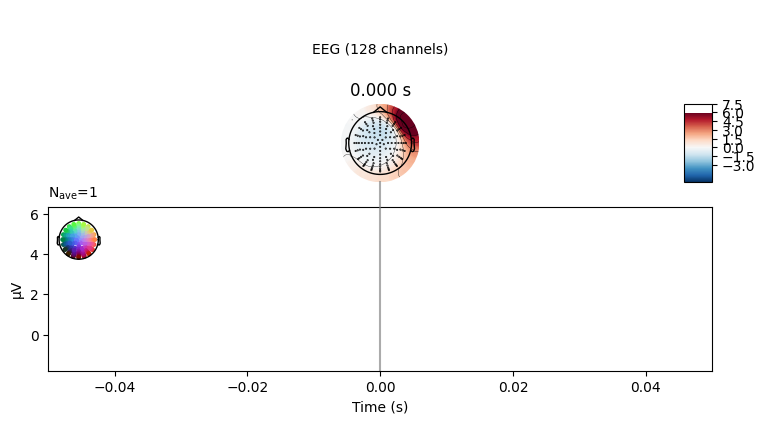

In [57]:
stc_ = stc.copy()
stc_.data[:, 0] = y_mask[0]
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Maks', 'title',
               font_size=14)
evoked.plot_joint()

stc_ = stc.copy()
stc_.data = y[0].T
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'y', 'title',
               font_size=14)
evoked.plot_joint()


# Train

In [109]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Dropout
from tensorflow.keras import backend as K

n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 64
activation_function = "elu"
batch_size = 32
epochs = 50
dropout = 0.2

inputs = tf.keras.Input(shape=(n_dipoles), name='Input')

fc1 = Dense(n_dense_units, 
            activation=activation_function,
            name='FC1')(inputs)


fc2 = Dense(n_dense_units, 
            activation=activation_function,
            name='FC2')(fc1)

fc3 = Dense(n_dense_units, 
            activation=activation_function,
            name='FC3')(fc2)


# Masking
# lstm1 = Bidirectional(LSTM(n_lstm_units, return_sequences=False, 
#             input_shape=(None, n_dense_units), dropout=dropout), 
#             name='LSTM1')(fc1)

out = Dense(n_dipoles, 
            activation="softmax", 
            activity_regularizer=tf.keras.regularizers.L1(l1=0.001),
            name='Mask')(fc3)

model = tf.keras.Model(inputs=inputs, outputs=out, name='Prelocalizer')

model.compile(loss="binary_crossentropy", optimizer="adam")
model.summary()
model.fit(X_components, y_mask, epochs=epochs, batch_size=batch_size, validation_split=0.15)
# model.fit(X[:, 0], y_mask, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "Prelocalizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1284)]            0         
                                                                 
 FC1 (Dense)                 (None, 300)               385500    
                                                                 
 FC2 (Dense)                 (None, 300)               90300     
                                                                 
 FC3 (Dense)                 (None, 300)               90300     
                                                                 
 Mask (Dense)                (None, 1284)              386484    
                                                                 
Total params: 952,584
Trainable params: 952,584
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
266/266 [============================

KeyboardInterrupt: 

# Eval raw

In [113]:
# settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.001, target_snr=1e99)
settings = dict(number_of_sources=3, extents=1, duration_of_trial=0.001, target_snr=1e99)

sim_test = Simulation(fwd, info, settings).simulate(2)
X_test, y_test = prep_data(sim_test)
y_test_mask = make_mask(y_test, thresh=0.001)
X_test_components = (leadfield_norm.T @ X_test[:, 0].T).T
y_hat = model.predict(X_test_components)

# y_hat = model.predict(X_test[:, 0])

plt.figure()
plt.plot(y_hat[0])

plt.figure()
plt.plot(y_test_mask[0])
print(pearsonr(y_test_mask[0], y_hat[0]))

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1997.29it/s]


source data shape:  (1284, 1) (1284, 1)


100%|██████████| 2/2 [00:00<00:00, 285.90it/s]


1/1 [==============================] - 0s 39ms/step
(0.09802015725446608, 0.0004357912544491404)


# Eval Source

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 249.91it/s]

Using control points [0.         0.         0.36852185]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1/1 [==============================] - 0s 22ms/step
Using control points [0.00053018 0.00090707 0.00824954]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


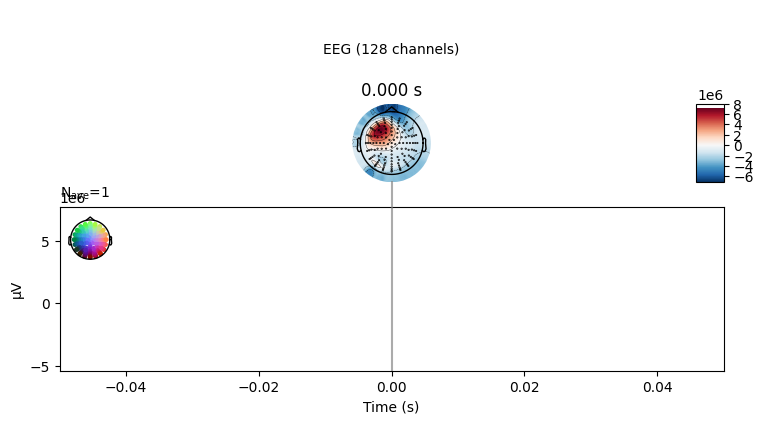

Using control points [0.00297994 0.00407218 0.0136928 ]


In [114]:
settings = dict(number_of_sources=3, extents=1, duration_of_trial=0.01, target_snr=1e99)

sim_test = Simulation(fwd, info, settings).simulate(2)
stc = sim_test.source_data[0]
evoked = sim_test.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

X_test, y_test = prep_data(sim_test)
y_mask_test = make_mask(y_test, thresh=0.001)
X_test_components = (leadfield_norm.T @ X_test[:, 0].T).T


y_hat = model.predict(X_test_components)[0]
Y_hat = np.diag(y_hat)
stc_ = stc.copy()
stc_.data *= 0
stc_.data[:, 0] = Y_hat @ leadfield.T

brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Predicted Mask', 'title',
               font_size=14)
evoked_ = mne.EvokedArray(leadfield @ y_hat[:, np.newaxis], info)
evoked_.plot_joint()

array([[7.7245488e-05, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 4.1818604e-04, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.0080886e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 8.9729219e-05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.5020541e-04, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0877433e-03]], dtype=float32)